In [1]:
%%capture --no-stderr
%pip install -U langgraph langchain-google-genai gloud dotenv


In [1]:
# Load API key.
from dotenv import load_dotenv
load_dotenv()


True

In [2]:
from typing import (
    Annotated,
    Sequence,
    TypedDict,
)
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages


class AgentState(TypedDict):
    """The state of the agent."""

    # add_messages is a reducer
    # See https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [3]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.tools import tool

model = ChatGoogleGenerativeAI(model="gemini-2.0-flash", temperature=0)


@tool
def get_weather(location: str):
    """Call to get the weather from a specific location."""
    # This is a placeholder for the actual implementation
    # Don't let the LLM know this though 😊
    if any([city in location.lower() for city in ["sf", "san francisco"]]):
        return "It's sunny in San Francisco, but you better look out if you're a Gemini 😈."
    else:
        return f"I am not sure what the weather is in {location}"


tools = [get_weather]

model = model.bind_tools(tools)

In [4]:
import json
from langchain_core.messages import ToolMessage, SystemMessage
from langchain_core.runnables import RunnableConfig

tools_by_name = {tool.name: tool for tool in tools}


# Define our tool node
def tool_node(state: AgentState):
    outputs = []
    for tool_call in state["messages"][-1].tool_calls:
        tool_result = tools_by_name[tool_call["name"]].invoke(tool_call["args"])
        outputs.append(
            ToolMessage(
                content=json.dumps(tool_result),
                name=tool_call["name"],
                tool_call_id=tool_call["id"],
            )
        )
    return {"messages": outputs}


# Define the node that calls the model
def call_model(
    state: AgentState,
    config: RunnableConfig,
):
    # this is similar to customizing the create_react_agent with 'prompt' parameter, but is more flexible
    system_prompt = SystemMessage(
        "You are a helpful AI assistant, please respond to the users query to the best of your ability!"
    )
    response = model.invoke([system_prompt] + state["messages"], config)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


# Define the conditional edge that determines whether to continue or not
def should_continue(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return "end"
    # Otherwise if there is, we continue
    else:
        return "continue"

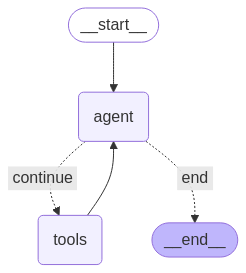

In [5]:
from langgraph.graph import StateGraph, END

# Define a new graph
workflow = StateGraph(AgentState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.set_entry_point("agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
    # Finally we pass in a mapping.
    # The keys are strings, and the values are other nodes.
    # END is a special node marking that the graph should finish.
    # What will happen is we will call `should_continue`, and then the output of that
    # will be matched against the keys in this mapping.
    # Based on which one it matches, that node will then be called.
    {
        # If `tools`, then we call the tool node.
        "continue": "tools",
        # Otherwise we finish.
        "end": END,
    },
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("tools", "agent")

# Now we can compile and visualize our graph
graph = workflow.compile()

from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [6]:
# Helper function for formatting the stream nicely
def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()


inputs = {"messages": [("user", "what is the weather in sf")]}
print_stream(graph.stream(inputs, stream_mode="values"))

================================ Human Message =================================

what is the weather in sf
================================== Ai Message ==================================
Tool Calls:
  get_weather (eb0fd35c-3016-45ae-a7f5-b6d1462b2461)
 Call ID: eb0fd35c-3016-45ae-a7f5-b6d1462b2461
  Args:
    location: sf
================================= Tool Message =================================
Name: get_weather

"It's sunny in San Francisco, but you better look out if you're a Gemini \ud83d\ude08."
================================== Ai Message ==================================

It's sunny in San Francisco, but you better look out if you're a Gemini 😈.


In [3]:
# First we initialize the model we want to use.
from langchain_google_genai import ChatGoogleGenerativeAI

model = ChatGoogleGenerativeAI(model="gemini-2.0-flash", temperature=0)


# For this tutorial we will use custom tool that returns pre-defined values for weather in two cities (NYC & SF)

from typing import Literal

from langchain_core.tools import tool


@tool
def get_weather(city: Literal["nyc", "sf"]):
    """Use this to get weather information."""
    if city == "nyc":
        return "It might be cloudy in nyc"
    elif city == "sf":
        return "It's always sunny in sf"
    else:
        raise AssertionError("Unknown city")


tools = [get_weather]


# Define the graph

from langgraph.prebuilt import create_react_agent

graph = create_react_agent(model, tools=tools)


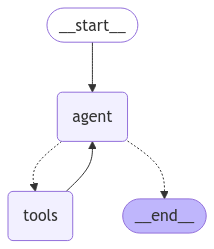

In [4]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [5]:
def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()

In [6]:
inputs = {"messages": [("user", "what is the weather in sf")]}
print_stream(graph.stream(inputs, stream_mode="values"))

================================ Human Message =================================

what is the weather in sf


================================== Ai Message ==================================
Tool Calls:
  get_weather (c0695689-d7a3-4fda-8ab6-4e6444f6ccd6)
 Call ID: c0695689-d7a3-4fda-8ab6-4e6444f6ccd6
  Args:
    city: sf
================================= Tool Message =================================
Name: get_weather

It's always sunny in sf
================================== Ai Message ==================================

It's always sunny in sf


In [7]:
inputs = {"messages": [("user", "who built you?")]}
print_stream(graph.stream(inputs, stream_mode="values"))

================================ Human Message =================================

who built you?
================================== Ai Message ==================================

I am a large language model, built by Google.
